## LASSO and Random Forest fits

# Load/import libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
#from sklearn.metrics import mean_squared_error,mean_absolute_error

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from preprocess import *

# Data

## Download

**Should really define a function that downloads the data and loads it**

In [3]:
# bxm,bym,jxm,jym,emfx,emfy,u2tot,b2tot
# tres,Rm,uave,kf,tt
pth='../data/alpha2/'

mf15 = np.load(pth + 'mfields_R15e3.npz')
mf9  = np.load(pth + 'mfields_R9e3.npz') 
mf5  = np.load(pth + 'mfields_R5e3.npz')
mf1  = np.load(pth + 'mfields_R1e3.npz') 
mf05 = np.load(pth + 'mfields_R5e2.npz')

## Pre-process

Time averaged data stored in a pandas dataframe

In [4]:
df15 = gen_df_tave(fname=pth + 'mfields_R15e3.npz',t1=1500,t2=-1,verbose=0)
df9  = gen_df_tave(fname=pth + 'mfields_R9e3.npz',t1=1500,t2=-1,verbose=0)
df5  = gen_df_tave(fname=pth + 'mfields_R5e3.npz',t1=1000,t2=-1,verbose=0)
df1  = gen_df_tave(fname=pth + 'mfields_R1e3.npz',t1=1250,t2=2000,verbose=0)
df05 = gen_df_tave(fname=pth + 'mfields_R5e2.npz',t1=4000,t2=5000,verbose=0)

# Lasso

In [5]:
from lasso_fits import *

## Linear basis

Test size: 0.2
Test,train shapes: (52, 4) (204, 4)
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.7s finished


Tuned Lasso Alpha: {'lasso__alpha': 0.01}
Tuned Lasso Score: -0.11922966761505314
BEST FIT model
Mean Absolute Error: 0.11922966761505314
LASSO score: 0.11238308368911176
Coefficients: [ 0.79561955 -0.00678383 -0.16492857  0.00930345]


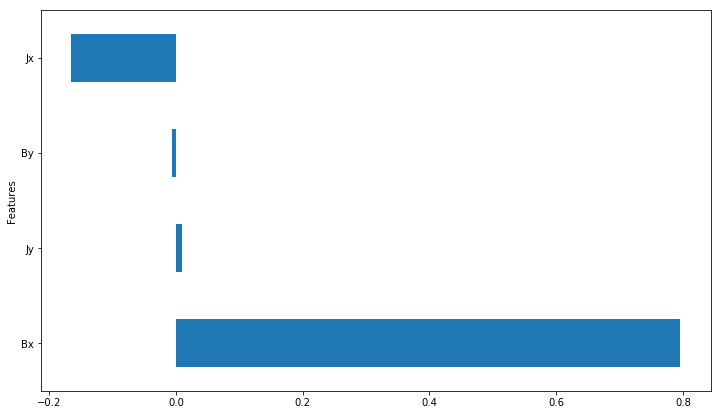

In [6]:
df15_ss, scl = scale_df(df15)
y_train,y_pred,y_test = lasso_gridcv(df15_ss)

# Random forests

In [7]:
from rf_fits import *

## Linear

Test size: 0.2
Test,train shapes: (52, 4) (204, 4)
Fitting 2 folds for each of 108 candidates, totalling 216 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


MAE: 0.08652315676576156
Tuned RF params: {'rf__max_depth': 8, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 2, 'rf__n_estimators': 16}
Tuned RF score:  -0.08652315676576156
MAE: 0.08652315676576156
R^2: 0.46345245436874194
Best model important features: SKLEARN
[0.77801629 0.00448691 0.21156309 0.00593372]


[Parallel(n_jobs=4)]: Done 216 out of 216 | elapsed:    0.8s finished


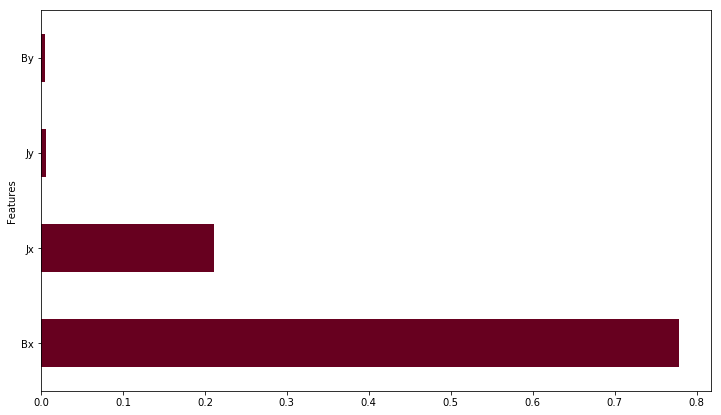

In [8]:
df15_ss, _ = scale_df(df15)
y_trainrf,y_predrf,y_testrf = rf_gridcv(df15_ss)#, fi_plts=True)

## Visualize individual trees

In [9]:
# Load the best model chosen by grid search

from joblib import load
bst_rf = load('bst_rf.joblib')
estimator = bst_rf.estimators_[5]
estimator

DecisionTreeRegressor(criterion='mae', max_depth=8, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1201263687, splitter='best')

In [10]:
from sklearn.tree import export_graphviz
import pydotplus
import collections
#from IPython import display

flds = ['Ex','Ey']
df_feats = df15_ss.drop(flds,axis=1)

tree0 = export_graphviz(estimator,
                feature_names=df_feats.columns,
                filled=True,
                rounded=True,
                rotate=True)
#display.display(tree0)

graph = pydotplus.graph_from_dot_data(tree0)

colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])
        
graph.write_png('tree.png')

True

In [11]:
# Uncomment to display the tree in jupyter 
#from IPython.display import Image
#Image(graph.create_png())

## Sci-kit Learn's Feature Importances

In [12]:
from joblib import load
bst_rf = load('bst_rf.joblib')
bst_rf.feature_importances_

array([0.77801629, 0.00448691, 0.21156309, 0.00593372])

In [13]:
bst_lasso = load('bst_lasso.joblib')
bst_lasso.coef_

array([ 0.79561955, -0.00678383, -0.16492857,  0.00930345])

In [14]:
flds = ['Ex','Ey']
df_feats = df15_ss.drop(flds,axis=1)
x_feats = list(df_feats.columns)

In [15]:
#plt.bar(x_feats, bst_rf.feature_importances_, color=['red','green','blue','black'])
#plt.bar(x_feats, bst_lasso.coef_, color=['k','y','k','y'])

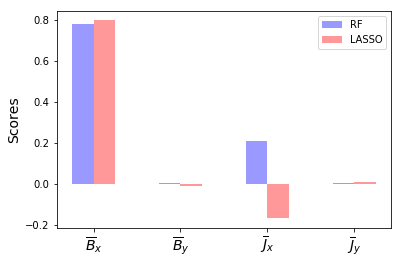

In [25]:
n_groups = 4
index = np.arange(n_groups)
bar_width = 0.25
xlabs = [r'$\overline{B}_x$', r'$\overline{B}_y$', 
         r'$\overline{J}_x$', r'$\overline{J}_y$']

opacity = 0.4
error_config = {'ecolor': '0.3'}

fig, ax = plt.subplots()

rects1 = ax.bar(index, bst_rf.feature_importances_, bar_width,
                alpha=opacity, color='b',
                #yerr=std_men, error_kw=error_config,
                label='RF')

rects2 = ax.bar(index + bar_width, bst_lasso.coef_, bar_width,
                alpha=opacity, color='r',
                #yerr=std_women, error_kw=error_config,
                label='LASSO')

#ax.set_xlabel('Fields')
ax.set_ylabel('Scores', fontsize=14)
#ax.set_title('Scores by group and gender')
ax.set_xticks(index + bar_width / 2)
#ax.set_xticklabels(x_feats)
ax.set_xticklabels(xlabs, fontsize=14)
ax.legend()

#fig.tight_layout()
#plt.show()

fig.savefig('RFvsLASSO.pdf', bbox_inches='tight')

## Comparison: RF vs LASSO

In [17]:
print(y_pred.shape,y_predrf.shape)

(52,) (52,)


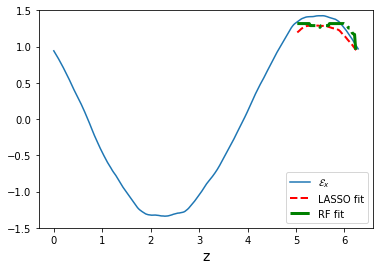

In [18]:
z_ax = np.linspace(0,2*np.pi,256)

fig,ax=plt.subplots()
        
fld_label = r"$\mathcal{E}_x$" #if fld=='Ex' else r"$\mathcal{E}_y$"
        
ax.plot(np.linspace(0,2*np.pi,256),df15_ss['Ex'],label=fld_label)
ax.plot(z_ax[y_train.shape[0]:],y_pred,'r--',lw=2,label="LASSO fit")
ax.plot(z_ax[y_train.shape[0]:],y_predrf,'g-.',lw=3,label="RF fit")
        
ax.set_ylim([-1.5,1.5])
    
ax.legend()
ax.set_xlabel('z',fontsize=14)
    
fig.savefig('df15_SPACE_comparison.pdf',bbox_inches='tight')

## Run through the rest of the models

In [19]:
df_list = {'df05':df05, 'df1':df1, 'df5':df5, 'df9':df9}#, 'df15':df15}

### LASSO

Data:  df05
Test size: 0.2
Test,train shapes: (52, 4) (204, 4)
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Tuned Lasso Alpha: {'lasso__alpha': 0.001}
Tuned Lasso Score: -0.005242940663544219
BEST FIT model
Mean Absolute Error: 0.005242940663544219
LASSO score: 0.9996152359413041
Coefficients: [ 0.11804596 -0.00981516 -0.88119021  0.        ]
Data:  df1
Test size: 0.2
Test,train shapes: (52, 4) (204, 4)
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Tuned Lasso Alpha: {'lasso__alpha': 0.001}
Tuned Lasso Score: -0.06800041596262422
BEST FIT model
Mean Absolute Error: 0.06800041596262422
LASSO score: 0.973233493714966
Coefficients: [ 0.50341704  0.08226693 -0.49331852  0.09500927]
Data:  df5
Test size: 0.2
Test,train shapes:

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


 (52, 4) (204, 4)
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Tuned Lasso Alpha: {'lasso__alpha': 0.001}
Tuned Lasso Score: -0.15915495738694485
BEST FIT model
Mean Absolute Error: 0.15915495738694485
LASSO score: 0.8180269157347644
Coefficients: [ 0.84486987  0.39399547 -0.         -0.01470044]
Data:  df9
Test size: 0.2
Test,train shapes: (52, 4) (204, 4)
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Tuned Lasso Alpha: {'lasso__alpha': 0.001}
Tuned Lasso Score: -0.044395917244967706
BEST FIT model


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


Mean Absolute Error: 0.044395917244967706
LASSO score: 0.9885721424732687
Coefficients: [ 0.77544571 -0.         -0.21802245  0.01393413]


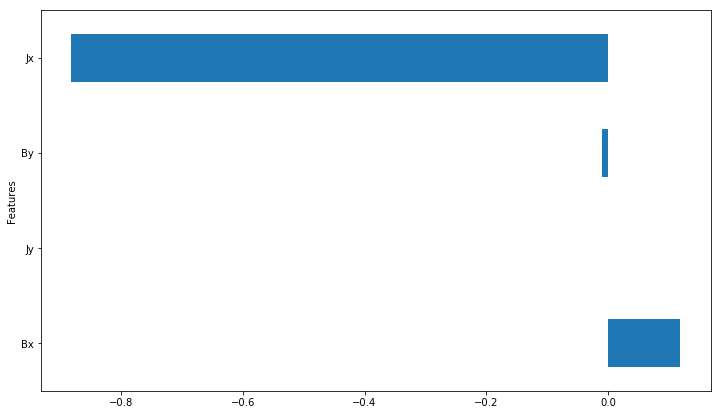

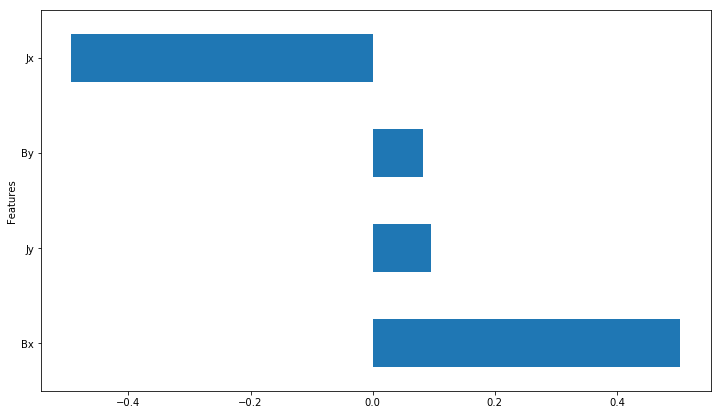

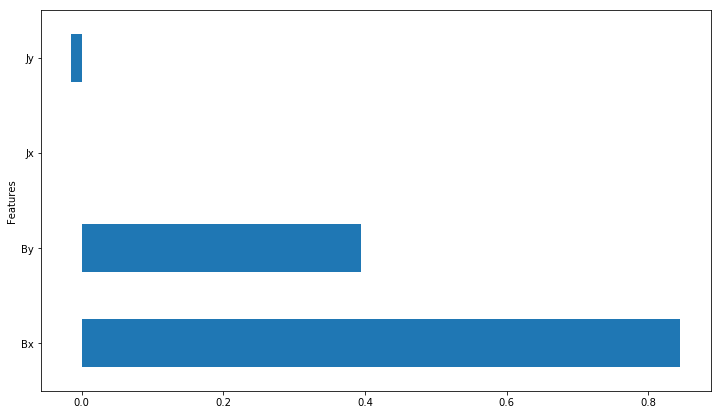

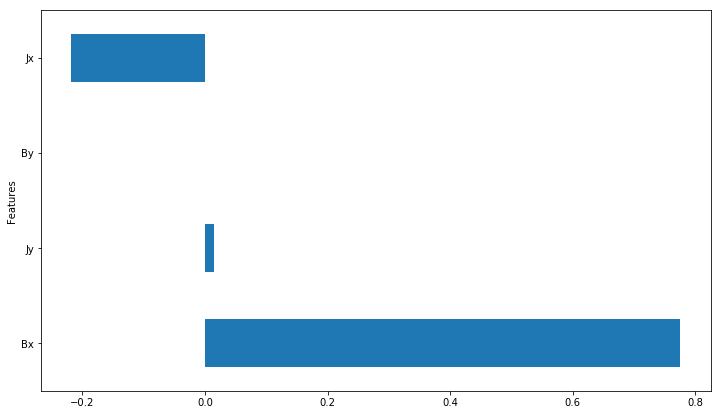

In [20]:
for key,data in df_list.items():
    data_ss, _ = scale_df(data)
    print('Data: ',key)
    lasso_gridcv(data_ss,name=key)#,fi_plts=True)

### Random Forests

Data:  df05
Test size: 0.2
Test,train shapes: (52, 4) (204, 4)
Fitting 2 folds for each of 108 candidates, totalling 216 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 216 out of 216 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


MAE: 0.09728642454361545
Tuned RF params: {'rf__max_depth': 4, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 2, 'rf__n_estimators': 8}
Tuned RF score:  -0.09728642454361545
MAE: 0.09728642454361545
R^2: 0.8305164627428137
Best model important features: SKLEARN
[0.20930425 0.00549457 0.78520118 0.        ]
Data:  df1
Test size: 0.2
Test,train shapes: (52, 4) (204, 4)
Fitting 2 folds for each of 108 candidates, totalling 216 fits


[Parallel(n_jobs=4)]: Done 216 out of 216 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


MAE: 0.15175169886926357
Tuned RF params: {'rf__max_depth': 8, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 2, 'rf__n_estimators': 4}
Tuned RF score:  -0.15175169886926357
MAE: 0.15175169886926357
R^2: 0.8568263261651737
Best model important features: SKLEARN
[0.03482231 0.02984677 0.92804777 0.00728315]
Data:  df5
Test size: 0.2
Test,train shapes: (52, 4) (204, 4)
Fitting 2 folds for each of 108 candidates, totalling 216 fits


[Parallel(n_jobs=4)]: Done 216 out of 216 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


MAE: 0.20096325532062215
Tuned RF params: {'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 4, 'rf__n_estimators': 16}
Tuned RF score:  -0.20096325532062215
MAE: 0.20096325532062215
R^2: 0.6170386128363334
Best model important features: SKLEARN
[0.26233767 0.26413925 0.42291189 0.05061119]
Data:  df9
Test size: 0.2
Test,train shapes: (52, 4) (204, 4)
Fitting 2 folds for each of 108 candidates, totalling 216 fits
MAE: 0.13432027188543527
Tuned RF params: {'rf__max_depth': 8, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 2, 'rf__n_estimators': 4}
Tuned RF score:  -0.13432027188543527
MAE: 0.13432027188543527
R^2: 0.813503214492775
Best model important features: SKLEARN
[0.74804391 0.00496667 0.22294496 0.02404447]


[Parallel(n_jobs=4)]: Done 216 out of 216 | elapsed:    0.9s finished


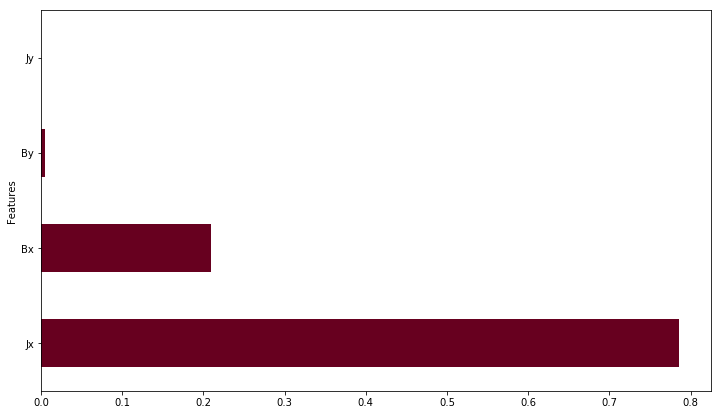

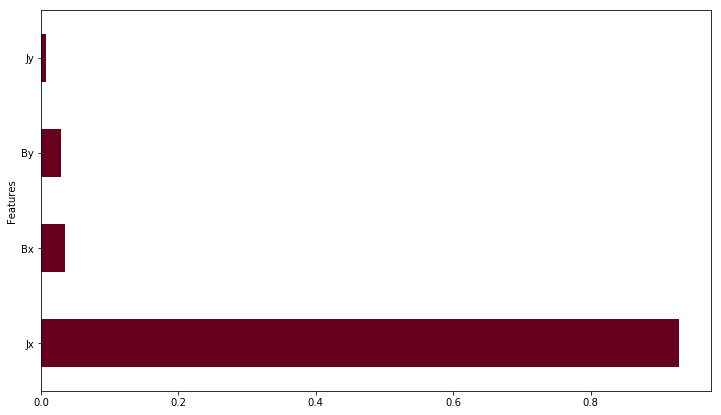

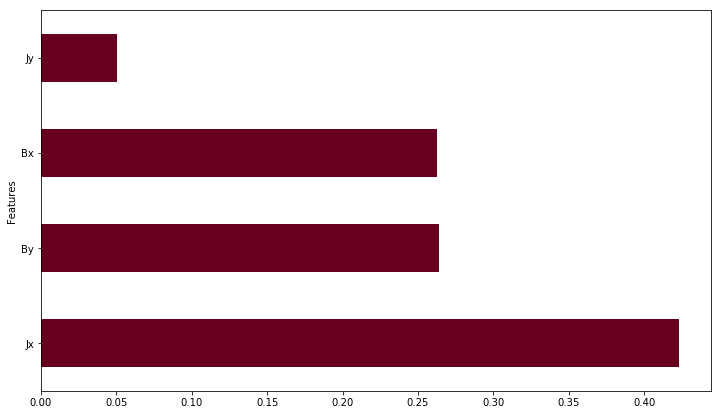

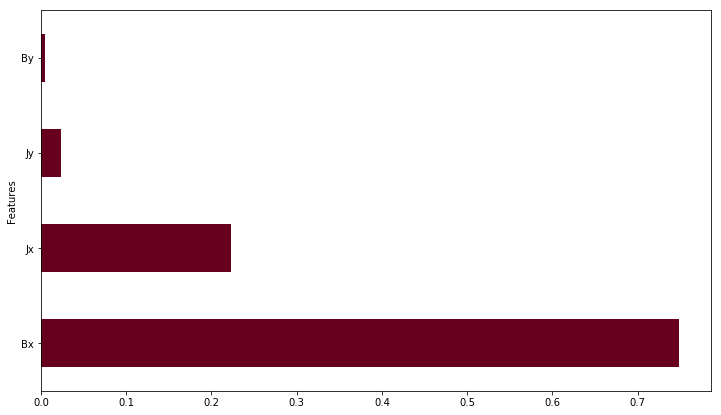

In [21]:
for key,data in df_list.items():
    data_ss,_ = scale_df(data)
    print('Data: ',key)
    rf_gridcv(data_ss,name=key)#,fi_plts=True)